# FE 630: Modern Portfolio Theory & Applications 
# Final Project 
# Compare 2 factor-based long/short allocation models with constraints on their betas

Team members
- Varun Seshu
- Darsh Sharma
- Sriram Bhardwaj
- Prakhyath Shivappa

Instructor: Papa Momar Ndiaye

# Introduction

We build and compare 2 factor-based long/short allocation models with contstraints on their beta values.

### The first strategy

The first strategy considers a target Beta in the interval [−0.5, 0.5], with a Value-at-Risk type of utlitity corresponding to Robust Optimization and is defined as

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\rho^{T}\omega-\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-0.5\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le0.5\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}

### The second strategy

The second strategy considers a target Beta in the interval [−1, +2] and incorporates an Information Ratio term to limit the deviations from a benchmark (SPY ETF) unless those deviations yield a high return.

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\frac{\rho^{T}\omega}{TEV(\omega)} -\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-1\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le2\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}


- $\omega$ is the portfolio weights to be maximized and recomputed during rebalancing the portfolio (weekly)
- $\Sigma$ is the the covariance matrix between the securities returns (computed from French Fama 3-factor Factor Model)
- $\lambda$ is a small regularization parameter to limit the turnover
- $\rho$ is the expected returns vector computed according to the period of the estimator used for this model
- $\beta_{i}^{m}=\frac{cov(r_{i},r_{M})}{\sigma^{2}(r_{M})}$ is the Beta of security $S_{i}$ as defined in the CAPM Model so that $\beta_{P}^{m}=\sum_{i=1}^{n}\beta_{i}^{m}\omega_{i}$ is the Beta of the Portfolio
- TEV($\omega$) is the Tracking Error Volatility = $\sigma(r_{P}(\omega)-r_{SPY})$

We compare the outcomes of the two models while evaluating their sensitivity to the the length of the estimators for covariance matrix and the expected returns under different market scenarios - namely before during and after the subprime mortgage crisis and the covid-19 crisis.

The portfolios will be reallocated (re-optimized every week for period of analysis from March 2007 to end of October 2022.


# French Fama 3-factor model

A three-factor model proposed by Fama and French(1993), includes not only market excess return, but a capitalization size and book to market ratio will also be added in as influencing factors.

The random return of a given security is given by

\begin{equation}
r_{i} = r_{f}+\beta_{i}^3(r_{M}-r_{f})+b_{i}^sr_{SMB}+b_{i}^vr_{HML}+\alpha_{i}+\epsilon_{i}
\end{equation}

The expected returns is given by 

\begin{equation}
\rho_{i} = r_{f}+\beta_{i}^3(\rho_{M}-r_{f})+b_{i}^s\rho_{SMB}+b_{i}^v\rho_{HML}+\alpha_{i}
\end{equation}


# Investment universe

The investment universe is a set of ETFs large enough to represent the World global economy
- CurrencyShares Euro Trust (FXE)
- iShares MSCI Japan Index (EWJ)
- SPDR GOLD Trust (GLD)
- Powershares NASDAQ-100 Trust (QQQ) 5. SPDR S&P 500 (SPY)
- iShares Lehman Short Treasury Bond (SHV) 7. PowerShares DB Agriculture Fund (DBA)
- United States Oil Fund LP (USO)
- SPDR S&P Biotech (XBI)
- iShares S&P Latin America 40 Index (ILF)
- iShares MSCI Pacific ex-Japan Index Fund (EPP) 12. SPDR DJ Euro Stoxx 50 (FEZ)

We also use the French Fama 3-factor model (Momentum, Value and Size).

# Benchmark

The benchmark will be the Market Portfolio S&P 500 ( SPY ETF).

# Estimators

We use trend following estimators for computing the Expected Returns vector ($\rho$) and the Covariance Matrix ($\sigma$). 

Furthermore, we consider 3 lookback periods for our estimators:
- Long-Term estimator (LT, 180 days)
- Mid-Term estimator (MT, 90 days)
- Short-Term estimator ( ST, 60 days)

The behavior of the optimal portfolio built from a specific com- bination of estimators for Covariance and Expected Return may change with the Market environment, a particular strategy being defined by a specific combination,
for example the notation $S_{90}^{40}$ - can be used to say that you are using 40 days estimation of covariance, 90 days for estimation of Expected Returns.

In this project, we consider the following estimators
- $S_{60}^{60}$
- $S_{60}^{90}$
- $S_{90}^{180}$
- $S_{90}^{60}$
- $S_{90}^{90}$
- $S_{90}^{180}$
- $S_{180}^{60}$
- $S_{180}^{90}$
- $S_{180}^{180}$


### Import required modules

In [1]:
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# 1. Data sourcing, processing and visualization

## Source asset data

In [2]:
def source_data(asset_list, start_date, end_date):
    # Create DATA folder if it doesn't exist
    if 'DATA' not in os.listdir():
        os.mkdir('./DATA')
        print("Created 'DATA' directory.")

    # Source and store data in the 'DATA' directory if it doesn't exist
    for asset in asset_list:
        if f"{asset}.csv" not in os.listdir("./DATA"):
            print(f"Sourcing data for {asset}")
            asset_data = yf.download(asset, start=start_date, end=end_date)
            asset_data.to_csv(f"./DATA/{asset}.csv")

    print("---------- COMPLETED SOURCING DATA ----------")

In [3]:
asset_list = [
    "FXE",
    "EWJ",
    "GLD",
    "QQQ",
    "SPY",
    "SHV",
    "DBA",
    "USO",
    "XBI",
    "ILF",
    "EPP",
    "FEZ"
]

start_date = "2007-03-01"
end_date = "2022-11-1"

source_data(asset_list, start_date, end_date)

---------- COMPLETED SOURCING DATA ----------


## Source French-Fama data

For the French-Fama data, we downloaded the zip file from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip, extracted it and put the data in the `DATA` folder created by the above function.


## Visualize sourced ETF price time-series data

The investment universe is a set of ETFs large enough to represent the World global economy
- CurrencyShares Euro Trust (FXE)
- iShares MSCI Japan Index (EWJ)
- SPDR GOLD Trust (GLD)
- Powershares NASDAQ-100 Trust (QQQ) 5. SPDR S&P 500 (SPY)
- iShares Lehman Short Treasury Bond (SHV) 7. PowerShares DB Agriculture Fund (DBA)
- United States Oil Fund LP (USO)
- SPDR S&P Biotech (XBI)
- iShares S&P Latin America 40 Index (ILF)
- iShares MSCI Pacific ex-Japan Index Fund (EPP) 12. SPDR DJ Euro Stoxx 50 (FEZ)

In [4]:
# Create DATA dict to store all dataframes of data
DATA = {}

os.listdir('DATA')
for csv in os.listdir('DATA'):
    DATA[csv[:-4]] = pd.read_csv(f"./DATA/{csv}", parse_dates=True, index_col=0)


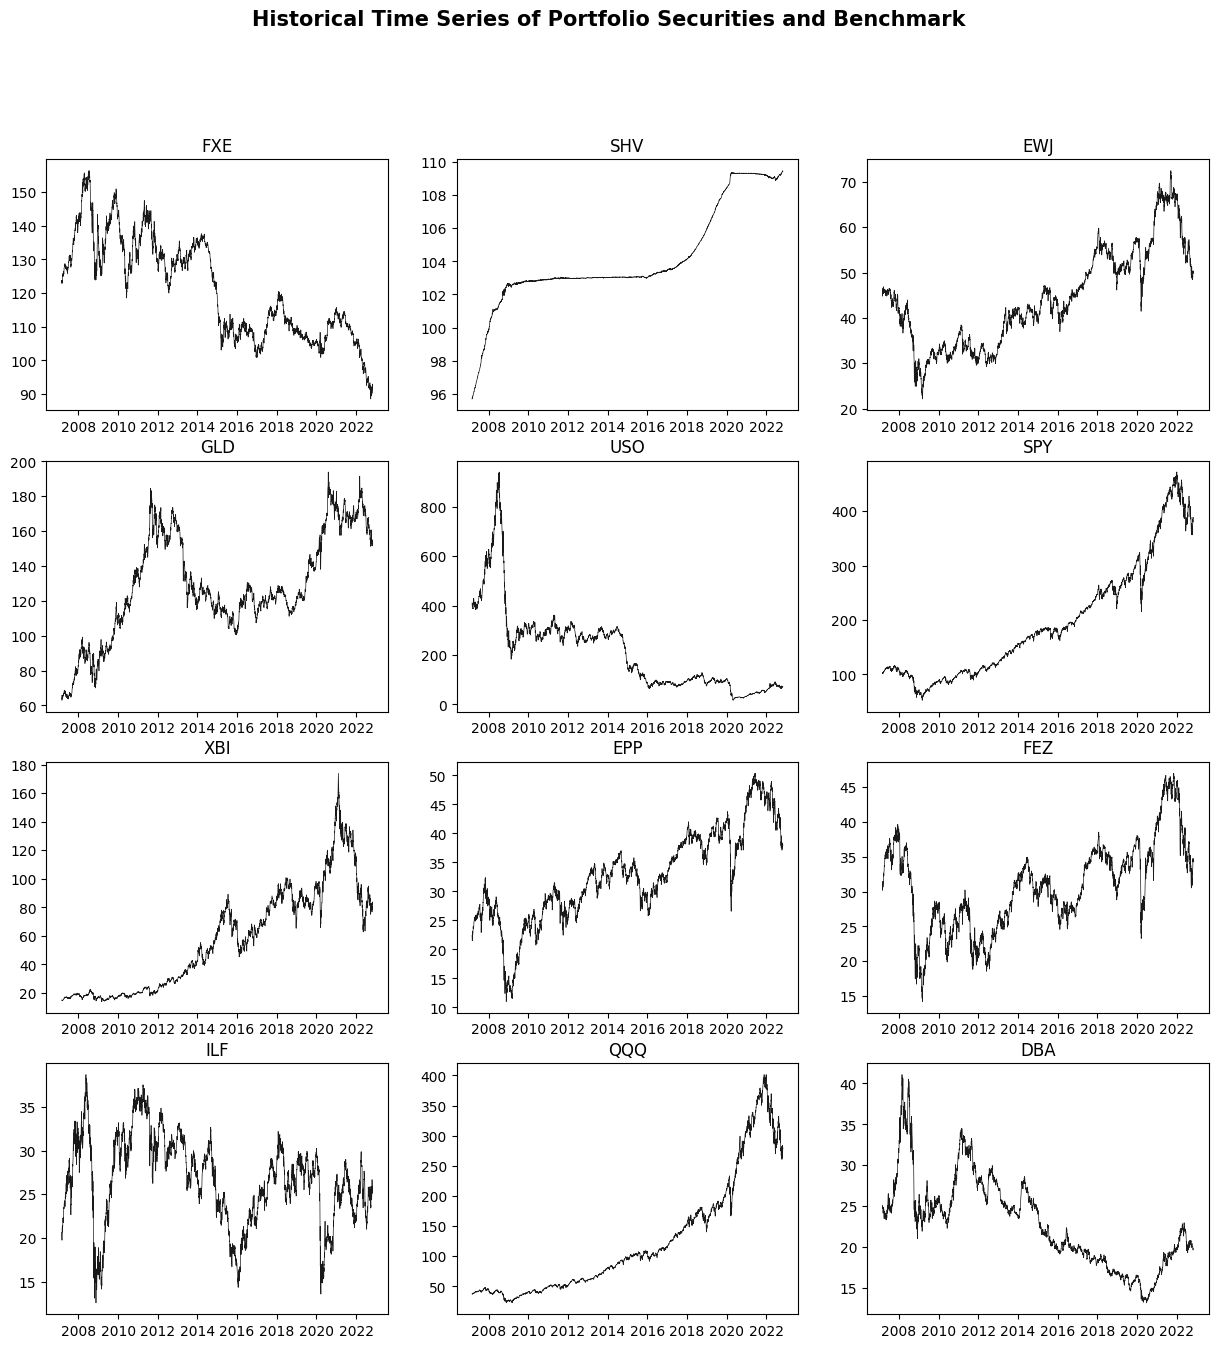

In [5]:
# Plot prices of all 12 ETFs
prices_plot, axes = plt.subplots(4,3,figsize=(15, 15))
prices_plot.suptitle('Historical Time Series of Portfolio Securities and Benchmark', fontweight='bold', fontsize=15)

ETFs = list(DATA.keys() - ['FrenchFama'])

etf_id = -1

for i in range(len(axes)):
    for j in range(len(axes[0])):
        etf_id += 1
        axes[i, j].plot(DATA[ETFs[etf_id]]['Adj Close'], 'black', linewidth=0.5, alpha=0.9)
        axes[i, j].set_title(ETFs[etf_id])


## Process French Fama data

In [6]:
# Remove last line consisting of copyright data
DATA['FrenchFama'].drop(DATA['FrenchFama'].tail(1).index ,inplace=True)

# Convert index column to datetime
DATA['FrenchFama'].index = pd.to_datetime(DATA['FrenchFama'].index)

# Crop data to relevant time period
DATA['FrenchFama'] = DATA['FrenchFama'][DATA['FrenchFama'].index >= '2007-03-01']

# Display French Fama data
DATA['FrenchFama']

,Mkt-RF,SMB,HML,RF
2007-03-01,-0.25,-0.11,0.15,0.019
2007-03-02,-1.24,-0.64,0.26,0.019
2007-03-05,-1.11,-0.69,-0.31,0.019
2007-03-06,1.58,0.65,-0.02,0.019
2007-03-07,-0.21,-0.09,0.08,0.019
...,...,...,...,...
2022-10-25,1.78,1.35,-1.52,0.011
2022-10-26,-0.66,0.42,0.89,0.011
2022-10-27,-0.54,0.32,1.06,0.011
2022-10-28,2.33,-0.04,-0.34,0.011


# 2. Compute estimators

In [7]:
def expected_returns(period):
    expected_returns_matrix = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        expected_returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    expected_returns_matrix = expected_returns_matrix.pct_change(1).dropna() * 250
    
    # Calculate rolling mean
    expected_returns_matrix = expected_returns_matrix.rolling(period).mean().dropna()[0::5]

    return expected_returns_matrix


In [8]:
# Compute and store the values of expected returns for 60, 90 and 180 days
DATA['expected_returns_60'] = expected_returns(60)
DATA['expected_returns_90'] = expected_returns(90)
DATA['expected_returns_180'] = expected_returns(180)

In [9]:
def covarince_matrix(period):
    returns_matrix = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Define list for covariance matrix
    covariance_matrices = []
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate covariance values
    while start + period <= len(returns_matrix)-1:
        covariance_matrices.append(returns_matrix.reset_index().iloc[start:start+period, :].cov(numeric_only=True))
        start += 5
    
    return covariance_matrices


In [10]:
# Compute and store the values of covariance matrices for 60, 90 and 180 days
DATA['covariance_matrix_60'] = covarince_matrix(60)
DATA['covariance_matrix_90'] = covarince_matrix(90)
DATA['covariance_matrix_180'] = covarince_matrix(180)

# 3. Calculate Beta values

In [11]:
def beta_values(period):
    
    returns_matrix = pd.DataFrame()
    beta_values = {}
    betas = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
        beta_values[etf] = []
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate beta_im values
    while start + period <= len(returns_matrix)-1:
        
        # Merges Returns data and french-fama factors to perform regression
        returns_french_fama = pd.merge(
            returns_matrix.reset_index().iloc[start:start+period, :], 
            DATA['FrenchFama'].reset_index().rename(columns={'index':'Date'}), 
            how='inner', 
            on='Date'
        )
        
        # Extract french fama factors
        french_fama_factors = np.array([returns_french_fama['Mkt-RF'], returns_french_fama['SMB'], returns_french_fama['HML']]).T
        
        # For each security
        for etf in etfs:
            # Calculate risk free returns
            returns_french_fama[f'{etf}_ri'] = returns_french_fama[etf] - returns_french_fama['RF']
            
            # Perform regression of factors on risk-free returns
            lr = LinearRegression().fit(french_fama_factors, returns_french_fama[f'{etf}_ri'])
            
            # Get coeffecients and intercept values
            alpha = lr.intercept_
            B = lr.coef_
            
            # Calculate residuals
            epsilon = returns_french_fama[f'{etf}_ri'] - (french_fama_factors.dot(B) + alpha)
            
            # Calculate r_m
            r_m = returns_french_fama['SPY']

            # Calculate r_i
            r_i = returns_french_fama['RF'] + (B[0]**3)*returns_french_fama['SMB'] + B[1]*returns_french_fama['SMB'] + B[2]*returns_french_fama['HML'] + alpha + epsilon
            
            # Calculte beta_im
            beta_im = np.cov(r_i,r_m)[0][1] / np.var(r_m,ddof=1)
            
            # Store beta_im
            beta_values[etf].append(beta_im)
            
            # break
            
        start += 5
        # break
    
    # Create dataframe of beta values
    for etf in etfs:
        betas[etf] = beta_values[etf]
    
    return betas


In [12]:
# Compute and store the values of betas for 60, 90 and 180 days
DATA['beta_values_60'] = beta_values(60)
DATA['beta_values_90'] = beta_values(90)
DATA['beta_values_180'] = beta_values(180)

# 4. Calculate and store returns

In [13]:
def returns_values(period):
    
    returns_matrix = pd.DataFrame()
    returns = []
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate beta_im values
    while start + period <= len(returns_matrix)-1:
        
        returns.append(returns_matrix.reset_index().iloc[start:start+period, :].drop(['Date'], axis=1))
        
        start += 5
        
    return returns


In [14]:
# Compute and store the values of returns for 60, 90 and 180 days
DATA['returns_values_60'] = returns_values(60)
DATA['returns_values_90'] = returns_values(90)
DATA['returns_values_180'] = returns_values(180)

# 5. First Strategy

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\rho^{T}\omega-\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-0.5\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le0.5\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}

In [15]:
def first_strategy(rho, sigma, lambda_, beta):
    # Set the variable weights
    omega = cp.Variable(n)
    
    # Compute cholesky decomposition of sigma
    L = np.linalg.cholesky(sigma)

    # Define objective funtion to minimize
    objective = (lambda_ * cp.norm(L@omega, 2)) - (rho.T @ omega)
    
    e = np.ones(n)
    
    # Define constraints
    constraints = [
        beta @ omega.T <= 0.5,
        -1 * (beta @ omega.T) <= 0.5,
        e @ omega.T == 1,
        omega <= [2 for i in range(n)],
        -1 * omega <= [2 for i in range(n)]
    ]
    
    # Solve problem and get optimal weights
    prob = cp.Problem(cp.Minimize(objective), constraints)
    result = prob.solve()
    
    return omega.value


# 6. Second Strategy

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\frac{\rho^{T}\omega}{TEV(\omega)} -\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-1\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le2\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}

In [16]:
# WORK IN PROGRESS

def second_strategy(rho, sigma, lambda_, beta, returns_matrix):
    omega = cp.Variable(n)
    L_sigma = np.linalg.cholesky(sigma)
#     print((np.array(returns_matrix) @ omega) - returns_matrix['SPY'])
#     TEV = 
#     L_TEV
    objective = (lambda_ * cp.norm(L_sigma @ omega, 2)) - (rho.T @ omega)/((np.array(returns_matrix) @ omega) - returns_matrix['SPY']) #(𝜎(𝑟𝑃(𝜔)−𝑟𝑆𝑃𝑌)))
    e = np.ones(n)
    constraints = [
        beta @ omega.T <= 2.0,
        -1 * (beta @ omega.T) <= 1.0,
        e @ omega.T == 1,
        omega <= [2 for i in range(n)],
        -1 * omega <= [2 for i in range(n)]
    ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    result = prob.solve()
    return omega.value

# n = len(asset_list)

# beta = np.array(DATA['beta_values_60'].iloc[0])
# sigma = np.array(DATA['covariance_matrix_60'][0])
# rho = np.array(DATA['expected_returns_60'].iloc[0])
# lambda_ = 0.01
# returns_matrix = DATA['returns_values_60'][0]

# second_strategy(rho, sigma, lambda_, beta, returns_matrix)

# Executing Strategy 1

# Executing Strategy 2

# Backtest

# Calculate metrics 

# Analyze results

# Insights